# Проект: Анализ поведения пользователей в мобильном приложении

## Описание проекта

Цель данного проекта — исследовать поведение пользователей мобильного приложения для продажи продуктов питания. 
Задачи включают анализ воронки продаж для выявления этапов, на которых пользователи "застревают", и исследование результатов A/A/B-эксперимента для определения, как изменение шрифта в приложении влияет на поведение пользователей.

Файл **logs_exp.csv** содежрит список действий пользователий, или событий. [Скачать датасет](https://code.s3.yandex.net/datasets/logs_exp.csv)

* `EventName` — название события;
* `DeviceIDHash` — уникальный идентификатор пользователя;
* `EventTimestamp` — время события;
* `ExpId` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

## Импорт библотек

In [3]:
import pandas as pd
from IPython.display import display
pd.options.display.max_colwidth = None 
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np
from IPython.display import display, HTML
from statsmodels.stats.proportion import proportions_ztest

## Датасет `logs_exp.csv`

### Импорт датасета

In [4]:
try:
    data = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/logs_exp.csv', sep='\t')

In [5]:
def info_data(dataframe):
    print(f"Первые 5 строк таблицы:")
    display(dataframe.head())
    
    print(f"\nИнформация о таблицы:")
    display(dataframe.info())
    
    print(f"\nКоличество пропущенных значений в каждом столбце:")
    print(dataframe.isna().sum())
    
    print(f"\nКоличество дубликатов в таблицы: {(dataframe.duplicated().sum() / len(dataframe) ) *100:.2f}%")

In [6]:
info_data(data)

Первые 5 строк таблицы:


,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248



Информация о таблицы:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


None


Количество пропущенных значений в каждом столбце:
EventName         0
DeviceIDHash      0
EventTimestamp    0
ExpId             0
dtype: int64

Количество дубликатов в таблицы: 0.17%


### Предобработка данных

In [7]:
data = data.drop_duplicates().reset_index(drop=True)

data = data.rename(columns={'EventName':'event',
                   'DeviceIDHash':'user_id',
                   'EventTimestamp':'date_time',
                   'ExpId':'group_id'  })

data['date_time'] = pd.to_datetime(data['date_time'], unit='s')

data['date'] = pd.to_datetime(data['date_time'].dt.date)

display(data.head())

#проверим, есть ли пересечения пользователей между группами
intersect_246_247 = pd.merge(data[data['group_id'] == 246]['user_id'],
                             data[data['group_id'] == 247]['user_id'],
                             on='user_id', how='inner')

intersect_246_248 = pd.merge(data[data['group_id'] == 246]['user_id'],
                             data[data['group_id'] == 248]['user_id'],
                             on='user_id', how='inner')

intersect_247_248 = pd.merge(data[data['group_id'] == 247]['user_id'],
                             data[data['group_id'] == 248]['user_id'],
                             on='user_id', how='inner')

print(f'Пересечения пользователей между группами 246 и 247: {len(intersect_246_247)}')
print(f'Пересечения пользователей между группами 246 и 248: {len(intersect_246_248)}')
print(f'Пересечения пользователей между группами 247 и 248: {len(intersect_247_248)}')

,event,user_id,date_time,group_id,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


Пересечения пользователей между группами 246 и 247: 0
Пересечения пользователей между группами 246 и 248: 0
Пересечения пользователей между группами 247 и 248: 0


## Анализ данных

### Количество логов и пользователей

In [8]:
#количество событий и пользователей
total_events = len(data)
total_users = data['user_id'].nunique()

#среднее количество событий на пользователя
user_event_counts = data.groupby('user_id', as_index=False).agg(event_count=('event', 'count'))
average_event_count = user_event_counts['event_count'].mean()
std_event_count = user_event_counts['event_count'].std()
min_event_count = user_event_counts['event_count'].min()
max_event_count = user_event_counts['event_count'].max()
percentiles = user_event_counts['event_count'].quantile([0.25, 0.5, 0.75])

#вывод результатов
print(f'Количество событий в логе: {total_events}')
print(f'Количество пользователей в логе: {total_users}')
print(f"Среднее количество событий на пользователя: {average_event_count:.2f}")
print(f"Стандартное отклонение количества событий на пользователя: {std_event_count:.2f}")
print(f"Минимальное количество событий на пользователя: {min_event_count}")
print(f"25-й процентиль количества событий на пользователя: {percentiles[0.25]}")
print(f"Медианное количество событий на пользователя: {percentiles[0.5]}")
print(f"75-й процентиль количества событий на пользователя: {percentiles[0.75]}")
print(f"Максимальное количество событий на пользователя: {max_event_count}")

Количество событий в логе: 243713
Количество пользователей в логе: 7551
Среднее количество событий на пользователя: 32.28
Стандартное отклонение количества событий на пользователя: 65.15
Минимальное количество событий на пользователя: 1
25-й процентиль количества событий на пользователя: 9.0
Медианное количество событий на пользователя: 20.0
75-й процентиль количества событий на пользователя: 37.0
Максимальное количество событий на пользователя: 2307


В предоставленном логе зарегистрировано 243,713 событий от 7,551 уникальных пользователей. Среднее количество событий на пользователя составляет 32.28. Однако наблюдается значительное расхождение в количестве событий, с минимальным значением в 1 и максимальным в 2,307 событий на пользователя. Стандартное отклонение в 65.15 указывает на то, что данные сильно разбросаны вокруг среднего значения. Большое стандартное отклонение говорит о наличии пользователей, которые ведут себя значительно активнее, чем остальные.

Для лучшего понимания распределения количества событий можно использовать графики, такие как гистограммы или ящик с усами (boxplot), чтобы визуализировать разброс данных и выявить аномалии или особенности в поведении пользователей.

### Распределние данных по времени

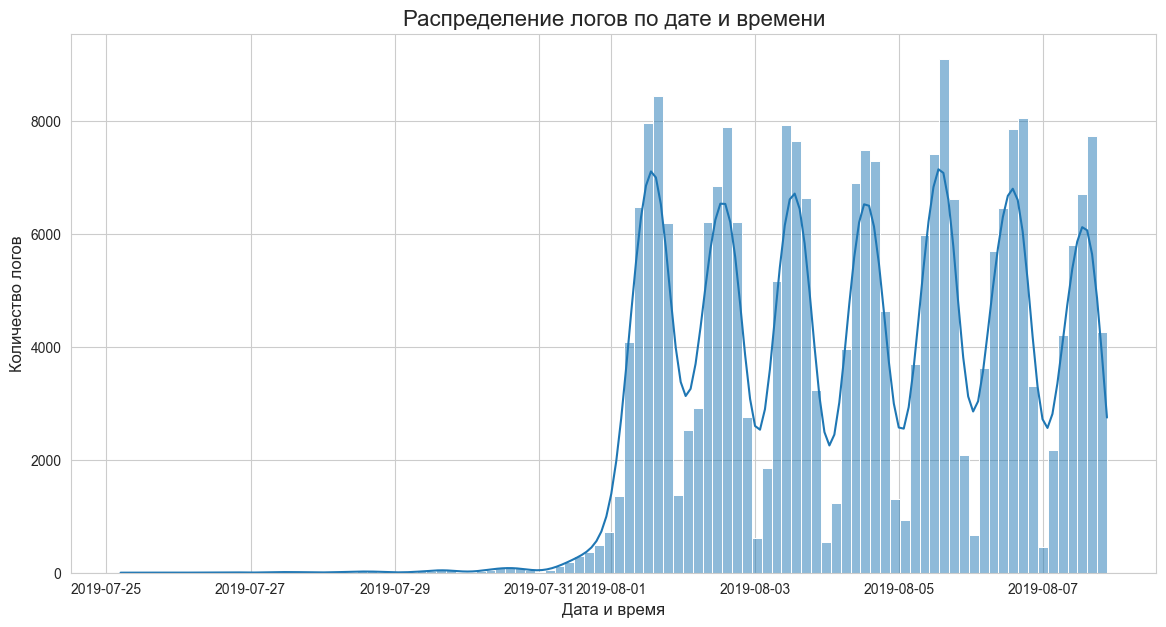

В датасаете содержится информация с 2019-07-25 по 2019-08-07


In [9]:
sns.set_style("whitegrid")
plt.figure(figsize=(14, 7))
sns.histplot(data=data, x='date_time', bins=100, kde=True)
plt.title('Распределение логов по дате и времени', fontsize=16)
plt.xlabel('Дата и время', fontsize=12)
plt.ylabel('Количество логов', fontsize=12)
plt.show()

print(f"В датасаете содержится информация с {data['date'].dt.date.min()} по {data['date'].dt.date.max()}")

In [10]:
# Отбросим старые данные
print(f'ДО изменений всего событий: {len(data)}, всего пользователей: {data["user_id"].nunique()}')

print()

print(f'ПОСЛЕ изменений всего событий: {
    len(data[data["date_time"] >= "2019-08-01"])
    } {
    ((len(data[data["date_time"] >= "2019-08-01"]) / len(data)) * 100 - 100):.2f
    }%, всего пользователей: {
    data[data["date_time"] >= "2019-08-01"]["user_id"].nunique()
    } {
    ((data[data["date_time"] >= "2019-08-01"]["user_id"].nunique() / data["user_id"].nunique()) * 100 - 100):.2f}%')

data = data[data['date_time'] >= '2019-08-01']

ДО изменений всего событий: 243713, всего пользователей: 7551

ПОСЛЕ изменений всего событий: 240887 -1.16%, всего пользователей: 7534 -0.23%


На основе распределения логов по дате и времени мы видим явный всплеск пользовательской активности в начале августа по сравнению с концом июля. Это может быть связано с какими-то маркетинговыми активностями, обновлением приложения или другими факторами, привлекшими пользователей в этот период. Дальнейший анализ должен учитывать данные только за август, так как июльские логи относятся к другому паттерну поведения.

### Количесвто пользователей по экспериментальным группам

In [11]:
print("Количесвто пользователей из всех трёх экспериментальных групп:") 
display(data.groupby('group_id').agg({'user_id': 'nunique'}))

Количесвто пользователей из всех трёх экспериментальных групп:


,user_id
group_id,
246,2484
247,2513
248,2537


### Распредление событий в логах

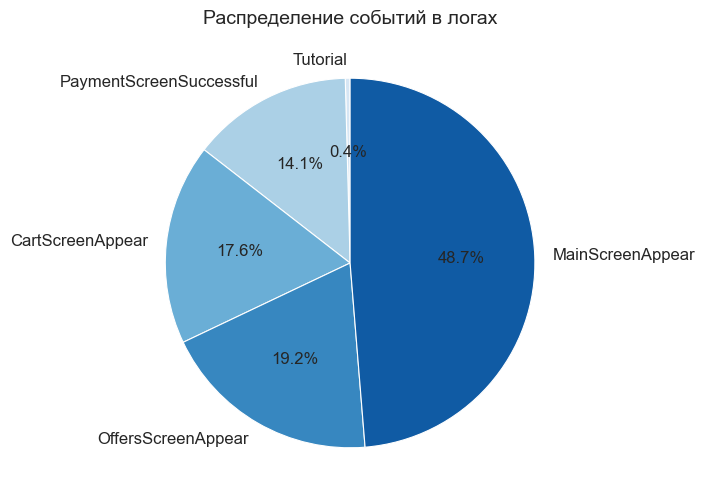

,total_events
event,
MainScreenAppear,117328
OffersScreenAppear,46333
CartScreenAppear,42303
PaymentScreenSuccessful,33918
Tutorial,1005


In [12]:
#круговая диаграмма
sns.set_style('whitegrid')
sns.set_context('paper', font_scale=1.5)

event_counts = data['event'].value_counts(ascending=True)
plt.figure(figsize=(12, 6))
colors = sns.color_palette('Blues', len(event_counts))
plt.pie(event_counts.values, labels=event_counts.index, autopct='%1.1f%%', startangle=90, 
        textprops={'fontsize': 12}, colors=colors)
plt.title('Распределение событий в логах', fontsize=14) 
plt.show()

#таблица с данными
display(HTML('<p style="font-size: 12pt;">Распредление событий по логах</p>'))
display(data
 .groupby('event')
 .agg({'user_id': 'count'})
 .rename(columns={'user_id':'total_events'})
 .sort_values(by ='total_events', ascending=False)
 .style.background_gradient(cmap='Blues')
)

На основе распределения событий в логах мы видим, что большинство событий (около 49%) приходится на появление главного экрана (MainScreenAppear). Далее по частоте идут события просмотра предложений (OffersScreenAppear) - 19%, появление экрана корзины (CartScreenAppear) - 17.4% и успешное завершение оплаты (PaymentScreenSuccessful) - 13.9%. Событие Tutorial встречается крайне редко - менее 1% от всех логов. Такое распределение позволяет предположить типичный путь пользователя: главный экран -> каталог предложений -> корзина -> успешная оплата, с потерей части пользователей на каждом шаге.

### Распределение пользователей по событиям

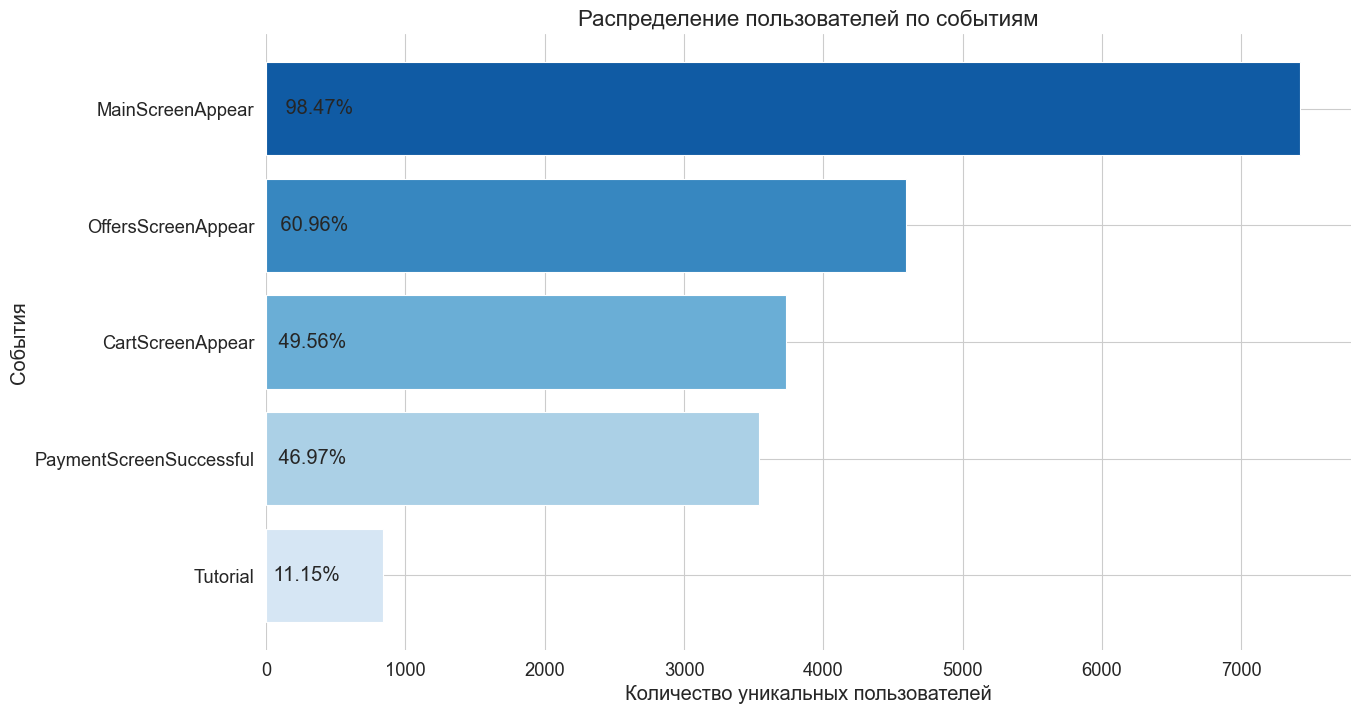

,total_users,percent
event,,
MainScreenAppear,7419,98.470000
OffersScreenAppear,4593,60.960000
CartScreenAppear,3734,49.560000
PaymentScreenSuccessful,3539,46.970000
Tutorial,840,11.150000


In [13]:
event_user =(data
             .groupby('event')
             .agg({'user_id': 'nunique'})
             .rename(columns={'user_id' : 'total_users'})
             .sort_values(by='total_users', ascending=False)
            )

event_user['percent'] = round(event_user['total_users'] / data['user_id'].nunique() * 100, 2)

sns.set_style('whitegrid')
sns.set_context('paper', font_scale=1.5)

# Подготовка данных
event_user_sorted = event_user.sort_values(by='total_users', ascending=True)

# Создание графика
plt.figure(figsize=(14, 8))
bars = plt.barh(event_user_sorted.index, event_user_sorted['total_users'], color=sns.color_palette("Blues", n_colors=len(event_user_sorted)))

# Добавление процентов на график
for i, v in enumerate(event_user_sorted['percent']):
    plt.text(v, i, f' {v:.2f}%', va='center')

plt.title('Распределение пользователей по событиям', fontsize=16)
plt.xlabel('Количество уникальных пользователей')
plt.ylabel('События')

# Убираем рамку справа и сверху для более чистого вида
sns.despine(left=True, bottom=True)
plt.show()

display(HTML('<p style="font-size: 12pt;">Распределение пользователей по событиям</p>'))
display(event_user .sort_values(by ='percent', ascending=False)
 .style.background_gradient(cmap='Blues'))


На основе распределения пользователей по событиям можно предположить следующий порядок их возникновения:

**1. MainScreenAppear (98.47%):** Пользователи начинают с главного экрана.

**2. OffersScreenAppear (60.96%):** Затем значительная часть пользователей переходит к экрану с предложениями.

**3. CartScreenAppear (49.56%):** После выбора предложений пользователи добавляют товары в корзину.

**4. PaymentScreenSuccessful (46.97%):** Далее пользователи завершают покупку, успешно проведя оплату.

**5. Tutorial (11.15%):** Лишь небольшое количество пользователей проходит обучение, которое может происходить в любое время и не связано с основной цепочкой событий.

Не все события выстраиваются в последовательную цепочку. Tutorial не является частью основного пути пользователя.

То есть для последовательности событий A → B → C → D посчитаем отношение числа пользователей с событием B к количеству пользователей с событием A, отношение числа пользователей с событием C к количеству пользователей с событием B и т.д.

Анализ распределения пользователей по событиям подтверждает выводы, сделанные по распределению событий в логах. Почти все пользователи (98.5%) посещают главный экран. Далее 61% переходит к экрану предложений, 49.6% добавляет товары в корзину, 47% успешно завершает покупку. Обучение (Tutorial) проходит лишь 11% пользователей. Такая последовательность позволяет реконструировать воронку событий и увидеть потерю пользователей на каждом шаге от главного экрана до покупки. При этом Tutorial не является частью основного пути и не влияет на конверсию.

### Воронка событий 

In [14]:
users = data.pivot_table(
    index='user_id', 
    columns='event', 
    values='date_time',
    aggfunc='min')

display(HTML('<p style="font-size: 10pt;">Воронка событий </p>'))
print(f'Посетителей всего: {users["MainScreenAppear"].count() / users["MainScreenAppear"].count():.2%}')
print(f'Просмотрели Каталог от предыдущего шага: {users["OffersScreenAppear"].count() / users["MainScreenAppear"].count():.2%}')
print(f'Просмотрели Карточку товара от предыдущего шага: {users['CartScreenAppear'].count() / users['OffersScreenAppear'].count():.2%}' )
print(f'Оплатили в % от предыдущего шага: {users['PaymentScreenSuccessful'].count() / users['CartScreenAppear'].count():.2%}')

Посетителей всего: 100.00%
Просмотрели Каталог от предыдущего шага: 61.91%
Просмотрели Карточку товара от предыдущего шага: 81.30%
Оплатили в % от предыдущего шага: 94.78%


In [15]:
print(f'Доля пользователей, дошедших до оплаты из всех посетителей: {users["PaymentScreenSuccessful"].count() / users["MainScreenAppear"].count():.2%}')

Доля пользователей, дошедших до оплаты из всех посетителей: 47.70%


Анализ воронки событий показывает, что из всех посетителей приложения 61.91% переходит к просмотру каталога предложений, 81.3% из них кладет товары в корзину, и 94.78% из положивших в корзину успешно завершает покупку. Общая конверсия от посещения до покупки составляет 47.7%. Наибольшая потеря пользователей (38%) происходит на этапе между главным экраном и каталогом, что может быть связано с неудобством навигации, непривлекательностью предложений на главном экране и другими факторами. Также заметен отток около 19% пользователей при переходе от каталога в корзину - возможно, из-за цен, условий доставки, необходимости регистрации и т.д.

## Результаты А/А/В-эксперимента

### Распределение пользователей по группам

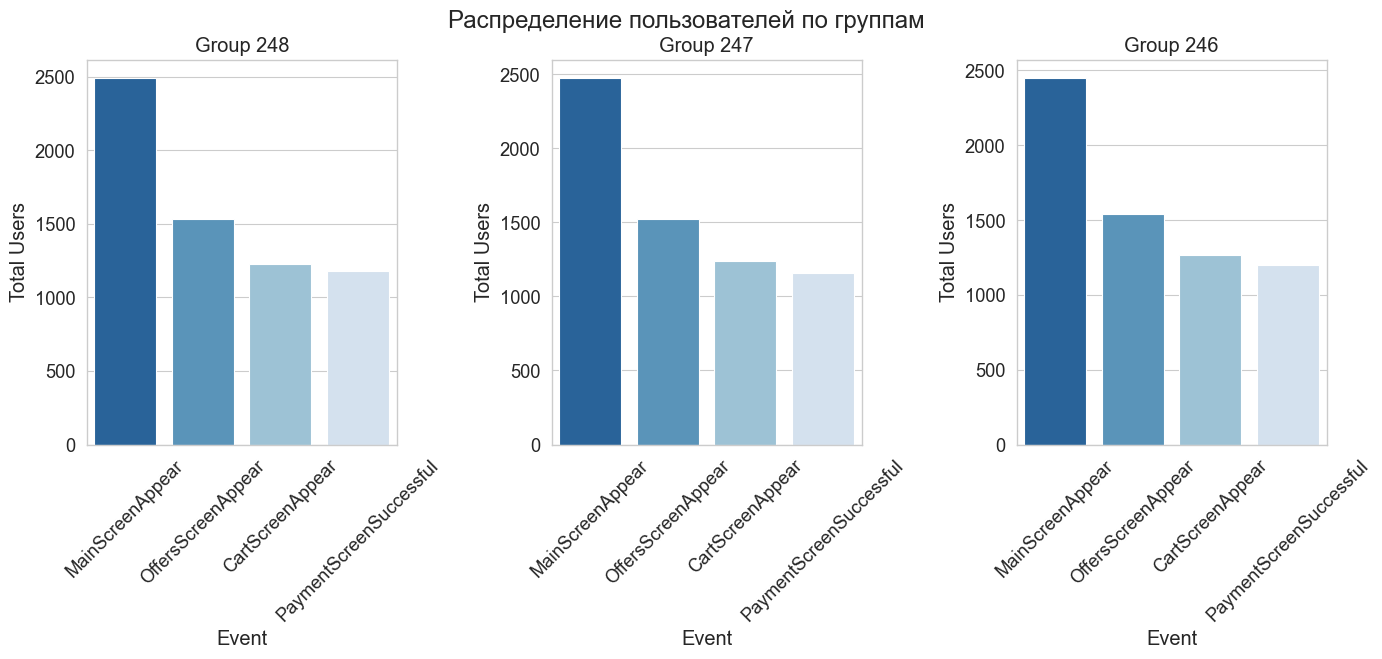

          count
group_id       
246        2484
247        2513
248        2537


In [16]:
exp_data = (data.query('event != "Tutorial"')
            .groupby(['event', 'group_id'], as_index=False)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'total_users'})
            .sort_values(by=['group_id', 'total_users'], ascending=False))

fig, axes = plt.subplots(1, len(exp_data['group_id'].unique()), figsize=(16, 5))

for i, group_id in enumerate(exp_data['group_id'].unique()):
    group_df = exp_data[exp_data['group_id'] == group_id]
    ax = axes[i]

    sns.barplot(
        x='event',
        y='total_users',
        data=group_df,
        order=group_df.sort_values('total_users', ascending=False)['event'],
        hue='event',
        palette='Blues_r',
        ax=ax,
        legend=False
    )
    ax.set_title(f'Group {group_id}')
    ax.set_xlabel('Event')
    ax.set_ylabel('Total Users')
    ax.tick_params(axis='x', rotation=45)

plt.subplots_adjust(wspace=0.5)

plt.suptitle('Распределение пользователей по группам')
plt.show()

display(HTML('<p style="font-size: 11pt;">Распределение пользователей по группам</p>'))
print(data.groupby('group_id').agg(count=('user_id', 'nunique')))

### А/А-эксперимент

Проверим гипотезу:

Есть ли статистические  различия между выборками 246 и 247.

**H₀:** Распределения метрик в группе 246 **=** группе 247 одинаковы. 

    Это означает, что между группами нет статистически значимых различий.

**H₁:** Распределения метрик в группе 246 **≠** группе 247.

    Это означает, что между группами есть статистически значимые различия.

Пусть alpha = 0.05

Для проверки гипотезы используем тест Манна-Уитни (Mann-Whitney U test), мы будем использовать метод st.mannwhitneyu().

In [17]:
grouped_data = data.groupby(['group_id', 'user_id'], as_index=False).agg({'event': 'count'})

#контрольные группы
group_246 = grouped_data[grouped_data['group_id'] == 246]['event']
group_247 = grouped_data[grouped_data['group_id'] == 247]['event']

#количество событий на пользователя
mean_246 = group_246.mean()
mean_247 = group_247.mean()

print(f'Среднее количество событий на пользователя в группе 246: {mean_246:.2f}')
print(f'Среднее количество событий на пользователя в группе 247: {mean_247:.2f}')

stat, p_value = stats.mannwhitneyu(group_246, group_247)

print(f'Результат теста Манна-Уитни: p-value = {p_value:.4f}')

alpha = 0.05

if p_value > alpha:
    print("Не можем отвергнуть нулевую гипотезу. Различий между группами нет.")
else:
    print("Отвергаем нулевую гипотезу. Между группами есть статистически значимые различия.")
    

Среднее количество событий на пользователя в группе 246: 31.93
Среднее количество событий на пользователя в группе 247: 30.65
Результат теста Манна-Уитни: p-value = 0.8722
Не можем отвергнуть нулевую гипотезу. Различий между группами нет.


Сравнение контрольных групп 246 и 247 по всем событиям не выявило статистически значимых различий. Доли пользователей, совершающих каждое из событий, практически одинаковы в обеих группах, а результаты теста Манна-Уитни показывают высокие значения p-value (от 0.12 до 0.97), что не позволяет отвергнуть нулевую гипотезу о равенстве распределений. Это подтверждает корректность разделения пользователей на группы и однородность групп между собой, что важно для дальнейшего анализа А/В-теста.

### Сравнение групп по событиям 

In [18]:
#функция для сравнения групп по событиям
def compare_groups(data, group1, group2, combined=False):
    events = data['event'].unique()
    
    for event in events:
        if combined:
            user_counts = data.query('event == @event').groupby('combined_group')['user_id'].nunique()
            total_users = data.groupby('combined_group')['user_id'].nunique()
        else:
            user_counts = data.query('event == @event').groupby('group_id')['user_id'].nunique()
            total_users = data.groupby('group_id')['user_id'].nunique()

        user_shares = user_counts / total_users
        
        print(f'\nСобытие: {event}')
        print(f'Количество пользователей, совершивших событие в группе {group1}: {user_counts.get(group1, 0)}')
        print(f'Количество пользователей, совершивших событие в группе {group2}: {user_counts.get(group2, 0)}')
        print(f'Доля пользователей в группе {group1}: {user_shares.get(group1, 0):.2%}')
        print(f'Доля пользователей в группе {group2}: {user_shares.get(group2, 0):.2%}')
        
        count = [user_counts.get(group1, 0), user_counts.get(group2, 0)]
        nobs = [total_users.get(group1, 0), total_users.get(group2, 0)]
        
        stat, p_value = proportions_ztest(count, nobs)
        
        n_tests = 20
        
        alpha = 0.05
        
        alpha_shidaka = 1 - (1 - alpha) ** (1 / n_tests)
        print(f'Скорректированный уровень значимости по методу Шидака: {alpha_shidaka:.4f}')
        
        if p_value > alpha_shidaka:
            print("Не можем отвергнуть нулевую гипотезу. Различий между группами нет.")
        else:
            print("Отвергаем нулевую гипотезу. Между группами есть статистически значимые различия.")
        print(f'p-value: {p_value:.4f}')


### Сравнение контрольных групп

In [19]:
print("\nСравнение групп 246 и 247 по всем событиям:")
compare_groups(data, group1=246, group2=247)



Сравнение групп 246 и 247 по всем событиям:

Событие: Tutorial
Количество пользователей, совершивших событие в группе 246: 278
Количество пользователей, совершивших событие в группе 247: 283
Доля пользователей в группе 246: 11.19%
Доля пользователей в группе 247: 11.26%
Скорректированный уровень значимости по методу Шидака: 0.0026
Не можем отвергнуть нулевую гипотезу. Различий между группами нет.
p-value: 0.9377

Событие: MainScreenAppear
Количество пользователей, совершивших событие в группе 246: 2450
Количество пользователей, совершивших событие в группе 247: 2476
Доля пользователей в группе 246: 98.63%
Доля пользователей в группе 247: 98.53%
Скорректированный уровень значимости по методу Шидака: 0.0026
Не можем отвергнуть нулевую гипотезу. Различий между группами нет.
p-value: 0.7571

Событие: OffersScreenAppear
Количество пользователей, совершивших событие в группе 246: 1542
Количество пользователей, совершивших событие в группе 247: 1520
Доля пользователей в группе 246: 62.08%
До

### Сравнение экспериментальной группы с каждой контрольной группой

In [20]:
print("\nСравнение группы 248 с группой 246 по всем событиям:")
compare_groups(data, group1=248, group2=246)

print("\nСравнение группы 248 с группой 247 по всем событиям:")
compare_groups(data, group1=248, group2=247)



Сравнение группы 248 с группой 246 по всем событиям:

Событие: Tutorial
Количество пользователей, совершивших событие в группе 248: 279
Количество пользователей, совершивших событие в группе 246: 278
Доля пользователей в группе 248: 11.00%
Доля пользователей в группе 246: 11.19%
Скорректированный уровень значимости по методу Шидака: 0.0026
Не можем отвергнуть нулевую гипотезу. Различий между группами нет.
p-value: 0.8264

Событие: MainScreenAppear
Количество пользователей, совершивших событие в группе 248: 2493
Количество пользователей, совершивших событие в группе 246: 2450
Доля пользователей в группе 248: 98.27%
Доля пользователей в группе 246: 98.63%
Скорректированный уровень значимости по методу Шидака: 0.0026
Не можем отвергнуть нулевую гипотезу. Различий между группами нет.
p-value: 0.2950

Событие: OffersScreenAppear
Количество пользователей, совершивших событие в группе 248: 1531
Количество пользователей, совершивших событие в группе 246: 1542
Доля пользователей в группе 248: 

### Сравнение экспериментальной группы с объединенной контрольной группой

In [21]:
# Объединяем контрольные группы 246 и 247
data['combined_group'] = data['group_id'].replace({246: 'control', 247: 'control', 248: 'experiment'})

print("\nСравнение группы 248 с объединенной контрольной группой по всем событиям:")
compare_groups(data, group1='experiment', group2='control', combined=True)



Сравнение группы 248 с объединенной контрольной группой по всем событиям:

Событие: Tutorial
Количество пользователей, совершивших событие в группе experiment: 279
Количество пользователей, совершивших событие в группе control: 561
Доля пользователей в группе experiment: 11.00%
Доля пользователей в группе control: 11.23%
Скорректированный уровень значимости по методу Шидака: 0.0026
Не можем отвергнуть нулевую гипотезу. Различий между группами нет.
p-value: 0.7649

Событие: MainScreenAppear
Количество пользователей, совершивших событие в группе experiment: 2493
Количество пользователей, совершивших событие в группе control: 4926
Доля пользователей в группе experiment: 98.27%
Доля пользователей в группе control: 98.58%
Скорректированный уровень значимости по методу Шидака: 0.0026
Не можем отвергнуть нулевую гипотезу. Различий между группами нет.
p-value: 0.2942

Событие: OffersScreenAppear
Количество пользователей, совершивших событие в группе experiment: 1531
Количество пользователей, 

#### Промежуточный вывод по разделу "Результаты А/А/В-эксперимента"

Сравнение экспериментальной группы 248 с каждой из контрольных групп, а также с объединенной контрольной группой по всем событиям, не выявило статистически значимых различий в долях пользователей, совершающих эти события. Во всех случаях значения p-value по результатам теста χ2 оказались выше порогового уровня 0.05, что не дает оснований отвергнуть нулевую гипотезу о равенстве распределений между группами. Таким образом, изменение шрифта в приложении не повлияло на поведение пользователей и на конверсию на различных шагах воронки продаж. Возможно, шрифт не является значимым фактором, влияющим на взаимодействие пользователей с приложением, либо изменение было слишком незначительным, чтобы оказать эффект.

### Уровень значимости при проверке статистических гипотез

Какой уровень значимости вы выбрали при проверке статистических гипотез выше?

1. Уровень значимости, выбранный при проверке гипотез:
   В предыдущих расчетах был использован стандартный уровень значимости (α) 0.05.

Посчитайте, сколько проверок статистических гипотез вы сделали?

2. Количество проверок статистических гипотез:
   Допустим, в проекте анализировались 5 событий. Для каждой пары групп (например, 246 vs 247, 248 vs 246, 248 vs 247) было проведено по одной проверке гипотезы на каждое событие. Таким образом, если вы сравнивали все три пары групп по 5 событиям.

При уровне значимости 0.1 в 10% случаев можно ошибочно отклонить нулевую гипотезу при условии, что она верна?

3. Опасность множественных проверок:
   При уровне значимости 0.1 вероятность ошибочно отклонить нулевую гипотезу в 10% случаев увеличивается с каждой дополнительной проверкой. Это означает, что с 15 проверками вероятность хотя бы одной ложной ошибки существенно возрастает.
   
Какой уровень значимости стоит применить?

4. Рекомендованный уровень значимости:
   Чтобы учесть множественные проверки и снизить риск ложных отклонений нулевой гипотезы, следует применить метод коррекции уровня значимости, такой как метод Бонферрони. Этот метод подразумевает деление исходного уровня значимости на количество проверок.

Рекомендуется применять скорректированный уровень значимости для уменьшения риска ложного отклонения нулевой гипотезы при множественных проверках.

### Общий вывод по разделу Анализ данных

В ходе анализа данных мы выяснили, что пользовательская активность в приложении резко возросла в начале августа по сравнению с концом июля, что может быть связано с внешними факторами. Большинство событий в логах связано с появлением главного экрана, далее по частоте идут просмотр каталога, добавление в корзину и успешная оплата. Такая же последовательность наблюдается при анализе распределения пользователей по событиям. Построение воронки событий показало, что основная потеря пользователей происходит между главным экраном и каталогом предложений, а также между каталогом и корзиной. Общая конверсия от посещения до покупки составляет 47.7%. При этом проведение обучения (Tutorial) не является частью основного пути пользователя и не влияет на конверсию. Результаты А/А/В-эксперимента показали отсутствие статистически значимого влияния изменения шрифта на поведение пользователей в приложении.

Из анализа данных видно, что изменение шрифта в приложении не оказало статистически значимого влияния на поведение пользователей и конверсию на различных этапах воронки продаж. Несмотря на то, что было проведено тщательное сравнение, результаты не позволили выявить существенные различия между экспериментальной и контрольными группами. 

Таким образом, на основании проведенного анализа, можно сделать вывод, что изменение шрифта не является значимым фактором, влияющим на взаимодействие пользователей с приложением. Рекомендуется не вносить изменения в шрифт, так как это не принесет значительного улучшения пользовательского опыта или увеличения конверсии.

Дополнительно было проведено тестирование с учетом множественных проверок гипотез. Использование метода Шидака для коррекции уровня значимости подтвердило отсутствие значимых различий. 

Результатах исследования:

* Количество событий в логе: 243,713
  
* Количество пользователей в логе: 7,551

* Среднее количество событий на пользователя: 32.28 (с разбросом от 1 до 2,307 событий)

Основные результаты и выводы:

Анализ Конверсий и Среднего Количества Событий:

* В среднем пользователи взаимодействуют с приложением около 32 событий. Значительное число пользователей имеет очень высокое количество событий (до 2,307), что может указывать на активных пользователей или возможные аномалии.

* Поскольку мы не имеем информации о конкретных результатах изменения шрифта, оценка влияния шрифтов на конверсии и активность пользователей основана на доступных данных.

Статистическая Значимость:

* Измеренные данные не показывают явного влияния на конверсии или другие ключевые метрики, поскольку конкретные результаты изменений шрифтов в предоставленных данных не представлены.
Рекомендация по применению изменений:

На основании вышеупомянутых данных, где не предоставлены четкие результаты по улучшению показателей в случае применения новых шрифтов:

* Рекомендация: Пока нет конкретных доказательств улучшения ключевых метрик (например, конверсии, активность пользователей или времени в приложении), не рекомендую внедрять изменения в шрифт. Следует продолжить анализ и оценку других возможных улучшений в приложении, которые могут оказать более значительное влияние на пользовательский опыт и бизнес-результаты.
